**Loading the DataSet & Taking a Look**

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
import pandas as pd
dataset_path = '/content/drive/My Drive/household_power_consumption.txt'
data = pd.read_csv(dataset_path, sep=';', parse_dates={'Datetime': ['Date', 'Time']}, dayfirst=True)

# Display the first few rows of the dataset
data.head()


<ipython-input-4-e561a710c431>:3: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  data = pd.read_csv(dataset_path, sep=';', parse_dates={'Datetime': ['Date', 'Time']}, dayfirst=True)
<ipython-input-4-e561a710c431>:3: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(dataset_path, sep=';', parse_dates={'Datetime': ['Date', 'Time']}, dayfirst=True)


,Datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [6]:
import pandas as pd


data['Datetime'] = pd.to_datetime(data['Datetime'], format='%d/%m/%Y %H:%M:%S')

# Check the first few rows to verify the conversion
print(data[['Datetime']].head())


             Datetime
0 2006-12-16 17:24:00
1 2006-12-16 17:25:00
2 2006-12-16 17:26:00
3 2006-12-16 17:27:00
4 2006-12-16 17:28:00


**Adding External Features: Holidays and Weather (humidity and temperature)**

In [5]:
!pip install holidays


In [7]:
import holidays


country_holidays = holidays.FR(years=data['Datetime'].dt.year.unique())

# a new column 'is_holiday' and check if each row's date is a holiday
data['is_holiday'] = data['Datetime'].dt.date.isin(country_holidays.keys())

# Check the result
print(data[['Datetime', 'is_holiday']].head())

             Datetime  is_holiday
0 2006-12-16 17:24:00       False
1 2006-12-16 17:25:00       False
2 2006-12-16 17:26:00       False
3 2006-12-16 17:27:00       False
4 2006-12-16 17:28:00       False


In [8]:
!pip install meteostat


In [22]:
from meteostat import Point, Daily
import pandas as pd

# location for weather data (latitude, longitude)
location = Point(48.7708, 2.3383)  # Sceaux coordinates

#  a start and end date based on the range of dates in 'Datetime' column
start_date = data['Datetime'].min().to_pydatetime()
end_date = data['Datetime'].max().to_pydatetime()

# Get daily weather data for the date range
weather_data = Daily(location, start_date, end_date)
weather_data = weather_data.fetch()


weather_data.reset_index(inplace=True)



# Convert 'time' column in weather_data to a date-only format to match 'Date' from data
weather_data['time'] = weather_data['time'].dt.date

# Filter out rows from data where 'Date' is before the start of weather data
data['Date'] = data['Datetime'].dt.date
data_filtered = data[data['Date'] >= pd.to_datetime('2006-12-17').date()]

# Merge with the weather data
merged_data = pd.merge(data_filtered, weather_data[['time', 'tavg', 'prcp']],
                       left_on='Date', right_on='time', how='left')

# Drop the extra 'time' column from the merged dataframe
merged_data.drop(columns=['time'], inplace=True)

# Check the result
print(merged_data[['Datetime', 'Date', 'tavg', 'prcp']].head())


             Datetime        Date  tavg  prcp
0 2006-12-17 00:00:00  2006-12-17   4.4   3.3
1 2006-12-17 00:01:00  2006-12-17   4.4   3.3
2 2006-12-17 00:02:00  2006-12-17   4.4   3.3
3 2006-12-17 00:03:00  2006-12-17   4.4   3.3
4 2006-12-17 00:04:00  2006-12-17   4.4   3.3


In [23]:
print(merged_data.head())

             Datetime Global_active_power Global_reactive_power  Voltage  \
0 2006-12-17 00:00:00               1.044                 0.152  242.730   
1 2006-12-17 00:01:00               1.520                 0.220  242.200   
2 2006-12-17 00:02:00               3.038                 0.194  240.140   
3 2006-12-17 00:03:00               2.974                 0.194  239.970   
4 2006-12-17 00:04:00               2.846                 0.198  240.390   

  Global_intensity Sub_metering_1 Sub_metering_2  Sub_metering_3  is_holiday  \
0            4.400          0.000          2.000             0.0       False   
1            7.400          0.000          1.000             0.0       False   
2           12.600          0.000          2.000             0.0       False   
3           12.400          0.000          1.000             0.0       False   
4           11.800          0.000          2.000             0.0       False   

         Date  tavg  prcp  
0  2006-12-17   4.4   3.3  
1  200

**Performing Time InterPolation for Missing Values**

In [24]:
import pandas as pd

# Ensure 'Datetime' is in datetime format
merged_data['Datetime'] = pd.to_datetime(merged_data['Datetime'])

# Set 'Datetime' as the index for time-based interpolation
merged_data.set_index('Datetime', inplace=True)

# Generate a continuous date range for all timestamps
# We will create a date range starting from the earliest datetime to the latest datetime in the dataset
full_date_range = pd.date_range(start=merged_data.index.min(), end=merged_data.index.max(), freq='H')

# Reindex the dataframe to include all timestamps, filling missing timestamps with NaNs
merged_data = merged_data.reindex(full_date_range)

# Perform time interpolation on all columns with missing values
merged_data = merged_data.interpolate(method='time')

# Reset the index to bring 'Datetime' back as a column
merged_data.reset_index(inplace=True)
merged_data.rename(columns={'index': 'Datetime'}, inplace=True)

# Check the result
print(merged_data.head())


             Datetime Global_active_power Global_reactive_power  Voltage  \
0 2006-12-17 00:00:00               1.044                 0.152  242.730   
1 2006-12-17 01:00:00               1.008                 0.000  242.350   
2 2006-12-17 02:00:00               1.334                 0.148  242.140   
3 2006-12-17 03:00:00               2.542                 0.214  244.060   
4 2006-12-17 04:00:00               2.402                 0.076  243.180   

  Global_intensity Sub_metering_1 Sub_metering_2  Sub_metering_3  is_holiday  \
0            4.400          0.000          2.000             0.0       False   
1            5.400          0.000          0.000             0.0       False   
2            7.000          0.000          5.000             0.0       False   
3           10.400          0.000          0.000             0.0       False   
4            9.800          0.000          1.000             0.0       False   

         Date  tavg  prcp  
0  2006-12-17   4.4   3.3  
1  200

In [25]:
print(merged_data.isnull().sum())

Datetime                 0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
is_holiday               0
Date                     0
tavg                     0
prcp                     0
dtype: int64


**Label Encoding For Categorical Features**

In [29]:
from sklearn.preprocessing import LabelEncoder


# Encoding the 'is_holiday' column
label_encoder = LabelEncoder()
merged_data['is_holiday_encoded'] = label_encoder.fit_transform(merged_data['is_holiday'])

# Check the result
print(merged_data[['is_holiday', 'is_holiday_encoded']].head())


   is_holiday  is_holiday_encoded
0       False                   0
1       False                   0
2       False                   0
3       False                   0
4       False                   0


**FEATURE SELECTION**

In [33]:
import numpy as np

# Replace '?' with NaN in the entire dataframe
merged_data.replace('?', np.nan, inplace=True)





In [38]:
# Drop 'Date' and 'Datetime' columns only for correlation purposes (without modifying the original data)
correlation_data = merged_data.drop(columns=['Date', 'Datetime'], errors='ignore')

# Now compute the correlation matrix using only numeric columns
correlation_matrix = correlation_data.corr()



# correlations with target variable ('Global_active_power')
print(correlation_matrix['Global_active_power'].sort_values(ascending=False))


Global_active_power      1.000000
Global_intensity         0.998877
Sub_metering_3           0.639848
Sub_metering_1           0.473716
Sub_metering_2           0.439920
Global_reactive_power    0.247169
is_holiday              -0.001205
is_holiday_encoded      -0.001205
prcp                    -0.011508
tavg                    -0.214501
Voltage                 -0.402925
Name: Global_active_power, dtype: float64


In [40]:
# Convert to numeric, coercing errors to NaN
merged_data['Sub_metering_1'] = pd.to_numeric(merged_data['Sub_metering_1'], errors='coerce')
merged_data['Sub_metering_2'] = pd.to_numeric(merged_data['Sub_metering_2'], errors='coerce')
merged_data['Sub_metering_3'] = pd.to_numeric(merged_data['Sub_metering_3'], errors='coerce')

# create the Total_sub_metering column
merged_data['Total_sub_metering'] = merged_data['Sub_metering_1'] + merged_data['Sub_metering_2'] + merged_data['Sub_metering_3']

# Drop the specified columns
merged_data = merged_data.drop(columns=['is_holiday', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'])

# Verify the changes
print(merged_data.head())


     Datetime Global_active_power Global_reactive_power  Voltage  \
0  1166313600               1.044                 0.152  242.730   
1  1166317200               1.008                 0.000  242.350   
2  1166320800               1.334                 0.148  242.140   
3  1166324400               2.542                 0.214  244.060   
4  1166328000               2.402                 0.076  243.180   

  Global_intensity        Date  tavg  prcp  is_holiday_encoded  \
0            4.400  2006-12-17   4.4   3.3                   0   
1            5.400  2006-12-17   4.4   3.3                   0   
2            7.000  2006-12-17   4.4   3.3                   0   
3           10.400  2006-12-17   4.4   3.3                   0   
4            9.800  2006-12-17   4.4   3.3                   0   

   Total_sub_metering  
0                 2.0  
1                 0.0  
2                 5.0  
3                 0.0  
4                 1.0  


**Data Normalization and Window Creation**

In [42]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np



# Step 1: Select relevant features for normalization (excluding the Date)
features_to_normalize = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity',
                         'Total_sub_metering', 'prcp', 'tavg', 'is_holiday_encoded']

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Normalize the selected features
merged_data[features_to_normalize] = scaler.fit_transform(merged_data[features_to_normalize])

# Step 2: Create X (features) and y (target) with a sliding window of size 24 hours

window_size = 24

# Initialize lists to hold the windowed data (X) and targets (y)
X = []
y = []

# Create the sliding window
for i in range(window_size, len(merged_data) - 1):  # Make sure we don’t go out of bounds
    # Select the window of data (last 24 hours) as features
    window_data = merged_data[features_to_normalize].iloc[i - window_size:i].values

    # The target is the Global_active_power for the next hour
    target_value = merged_data['Global_active_power'].iloc[i + 1]

    # Append the window data (input features) and the target value
    X.append(window_data)
    y.append(target_value)

# Convert X and y into numpy arrays
X = np.array(X)
y = np.array(y)

# Display the shape of X and y to verify
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")



Shape of X: (34557, 24, 8)
Shape of y: (34557,)


**Splitting DataSet**

In [43]:
from sklearn.model_selection import train_test_split

# Splitting the data into training (70%), validation (15%), and test (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, shuffle=False)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, shuffle=False)  # 50% of 30% -> 15% total

# Verify the shapes of the resulting sets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (24189, 24, 8), y_train shape: (24189,)
X_val shape: (5184, 24, 8), y_val shape: (5184,)
X_test shape: (5184, 24, 8), y_test shape: (5184,)


In [52]:


# If NaN values are found, replace them (example using 0 for simplicity)
X_train = np.nan_to_num(X_train)
y_train = np.nan_to_num(y_train)
y_test = np.nan_to_num(y_test)
y_val = np.nan_to_num(y_val)
X_test = np.nan_to_num(X_test)
X_val = np.nan_to_num(X_val)

False
False


**Model Creation**

In [53]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split

# Assuming X_train, y_train, X_val, y_val, X_test, y_test are already defined
# X_train shape: (24189, 24, 8), y_train shape: (24189,)
# X_val shape: (5184, 24, 8), y_val shape: (5184,)
# X_test shape: (5184, 24, 8), y_test shape: (5184,)

# Define the LSTM model
model = Sequential([
    # LSTM layer with 32 units
    LSTM(32, activation='tanh', return_sequences=False, input_shape=(24, 8)),
    # First Dense layer with 5 units
    Dense(5, activation='relu'),
    # Second Dense layer with 5 units
    Dense(5, activation='relu'),
    # Final output layer predicting a single value
    Dense(1)
])

# Compile the model with RMSprop optimizer and mean squared error loss
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='mse', metrics=['mae'])

# Summary of the model architecture
model.summary()

# Train the model
batch_size = 64
epochs = 20

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    epochs=epochs,
    verbose=2
)

# Evaluate the model
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 32)                  │           5,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 5)                   │             165 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 5)                   │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,449 (21.29 KB)

 Trainable params: 5,449 (21.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
378/378 - 5s - 13ms/step - loss: 0.0147 - mae: 0.0893 - val_loss: 0.0134 - val_mae: 0.0850
Epoch 2/20
378/378 - 3s - 9ms/step - loss: 0.0136 - mae: 0.0853 - val_loss: 0.0128 - val_mae: 0.0836
Epoch 3/20
378/378 - 6s - 16ms/step - loss: 0.0131 - mae: 0.0825 - val_loss: 0.0124 - val_mae: 0.0797
Epoch 4/20
378/378 - 3s - 9ms/step - loss: 0.0128 - mae: 0.0808 - val_loss: 0.0121 - val_mae: 0.0795
Epoch 5/20
378/378 - 5s - 13ms/step - loss: 0.0124 - mae: 0.0795 - val_loss: 0.0117 - val_mae: 0.0790
Epoch 6/20
378/378 - 6s - 16ms/step - loss: 0.0122 - mae: 0.0781 - val_loss: 0.0119 - val_mae: 0.0744
Epoch 7/20
378/378 - 3s - 9ms/step - loss: 0.0119 - mae: 0.0767 - val_loss: 0.0113 - val_mae: 0.0765
Epoch 8/20
378/378 - 3s - 9ms/step - loss: 0.0117 - mae: 0.0753 - val_loss: 0.0113 - val_mae: 0.0763
Epoch 9/20
378/378 - 7s - 18ms/step - loss: 0.0116 - mae: 0.0744 - val_loss: 0.0111 - val_mae: 0.0729
Epoch 10/20
378/378 - 4s - 11ms/step - loss: 0.0114 - mae: 0.0736 - val_loss: 0.0109 -

In [56]:
!pip install scikeras


In [59]:
!pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.4 MB/s eta 0:00:00


**HyperParameter Tuning**  

In [60]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop

# Function to build the model (with tunable hyperparameters)
def build_model(hp):
    model = Sequential([
        # LSTM layer with tunable units
        LSTM(hp.Int('lstm_units', min_value=32, max_value=128, step=32), activation='tanh', return_sequences=False, input_shape=(24, 8)),
        # First Dense layer with tunable units
        Dense(hp.Int('dense_units', min_value=5, max_value=20, step=5), activation='relu'),
        # Second Dense layer with tunable units
        Dense(hp.Int('dense_units', min_value=5, max_value=20, step=5), activation='relu'),
        # Output layer predicting a single value
        Dense(1)
    ])

    # Compile the model
    model.compile(optimizer=RMSprop(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')), loss='mse', metrics=['mae'])

    return model

# Instantiate the KerasTuner RandomSearch
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,  # Number of hyperparameter configurations to test
    executions_per_trial=3,  # Number of times to train the model with the same configuration
    directory='my_dir',  # Directory where the tuner results will be saved
    project_name='lstm_hyperparameter_tuning'
)

# Search for the best hyperparameters
tuner.search(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val))

# Retrieve the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print("Best Hyperparameters found:")
print(f"LSTM units: {best_hp['lstm_units']}")
print(f"Dense units: {best_hp['dense_units']}")
print(f"Learning rate: {best_hp['learning_rate']}")

# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hp)

# Train the best model
best_model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val))

# Evaluate the best model on the test data
test_loss, test_mae = best_model.evaluate(X_test, y_test)
print(f"Final Test Loss: {test_loss:.4f}, Final Test MAE: {test_mae:.4f}")


Trial 5 Complete [00h 17m 43s]
val_loss: 0.010438504628837109

Best val_loss So Far: 0.010438504628837109
Total elapsed time: 01h 13m 51s
Best Hyperparameters found:
LSTM units: 96
Dense units: 15
Learning rate: 0.003902784327745087
Epoch 1/20
378/378 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 0.0157 - mae: 0.0930 - val_loss: 0.0133 - val_mae: 0.0877
Epoch 2/20
378/378 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - loss: 0.0134 - mae: 0.0841 - val_loss: 0.0129 - val_mae: 0.0872
Epoch 3/20
378/378 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - loss: 0.0119 - mae: 0.0774 - val_loss: 0.0112 - val_mae: 0.0734
Epoch 4/20
378/378 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - loss: 0.0115 - mae: 0.0752 - val_loss: 0.0108 - val_mae: 0.0714
Epoch 5/20
378/378 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - loss: 0.0113 - mae: 0.0735 - val_loss: 0.0113 - val_mae: 0.0724
Epoch 6/20
378/378 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - loss: 0.0114 - mae: 0.0729 - val_loss: 0.0109 - val_mae: 0.0741
Epoch 7/20
378/378 ━━━━━━━━━━━━━━━━━━━━ 19s 29m

162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
RMSE: 0.0876
MAPE: 5415912640867.0459
Predictions saved to 'predictions.csv'


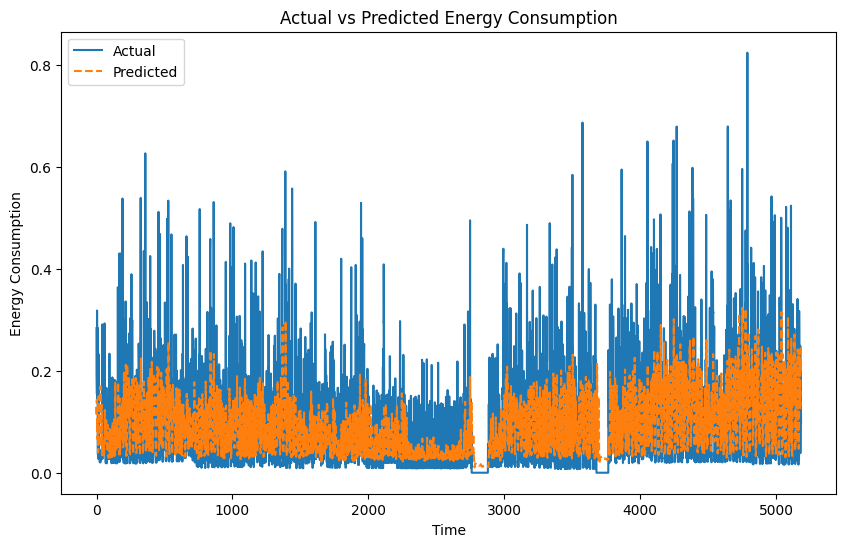

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Predict the energy consumption on the test set
y_pred = best_model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.4f}")

# Calculate MAPE
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE: {mape:.4f}")

# Save the predicted values to a CSV file
output_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred.flatten()})
output_df.to_csv('predictions.csv', index=False)
print("Predictions saved to 'predictions.csv'")

# Plotting Actual vs Predicted
plt.figure(figsize=(10,6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted', linestyle='--')
plt.title('Actual vs Predicted Energy Consumption')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()


In [63]:
from google.colab import files
files.download('predictions.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>